In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

>> #### Import Libraries

In [22]:
import dvc.api
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Plotting imports
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# CausalML imports
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
sm = StructureModel()


>> #### Import Required modules

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from load_data import LoadData
from plot import Plot
from overview import Overview
from preprocessing import PreProcess

Initialize load data

In [6]:
loader = LoadData()
plot = Plot()

Load data from csv file using DVC

In [7]:
# Get URL from DVC
data_path = '../data/data.csv'
repo = 'https://github.com/jedisam/Causal_inference'
version = 'bee80042c3c966ec98d90c247a8ccac0e5fd8aca'

In [ ]:
# Load train data from dvc using the dvc.api.Dataset class
data_url = dvc.api.get_url(
    path=data_path,
    repo=repo,
    rev=version
)

In [8]:
data = loader.read_csv("../data/data_clean.csv")

In [9]:
overview = Overview(data)
prep = PreProcess(data)

In [10]:
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.22862,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.62695,0.6869,0.2575,0.41915,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678,1


In [11]:
# Count missing values
overview.percent_missing(data)

The dataset contains 0.0 % missing values.


Display Feature importance

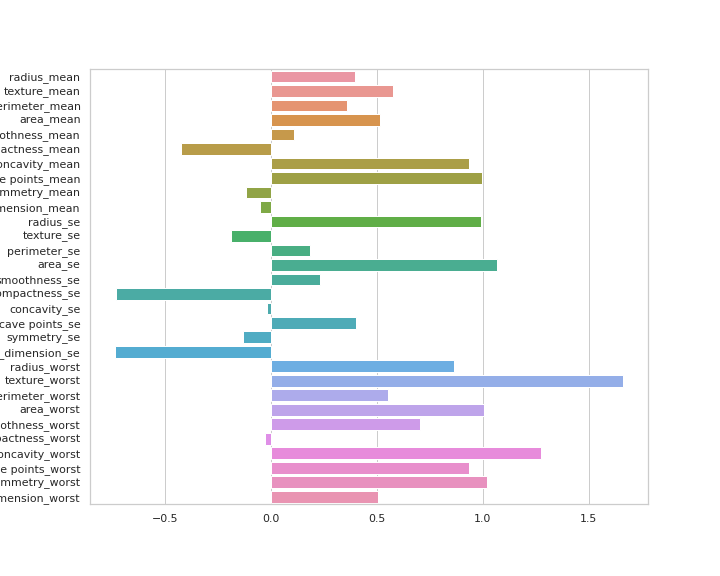

In [12]:
Image(filename='feature_importance.png') 

Based on the feature importance, we can see that the most important features are the ones that are most correlated with the target variable.
These are:

    > 'concave points_mean',
    > 'texture_mean',
    > 'concavity_mean',
    > 'concave points_mean',
    > 'radius_se',
    > 'radius_worst',
    > 'concave points_worst',
    > 'perimeter_worst',
    > 'area_mean',
    > 'area_worst',
    > 'perimeter_mean',
    > 'radius_mean'

In [13]:
sel_feat = data[['concave points_mean', 'texture_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'radius_worst', 'concave points_worst', 'perimeter_worst', 'area_mean', 'area_worst', 'perimeter_mean', 'radius_mean']]

In [14]:
sel_feat.head()

,concave points_mean,texture_mean,concavity_mean,concave points_mean,radius_se,radius_worst,concave points_worst,perimeter_worst,area_mean,area_worst,perimeter_mean,radius_mean
0,0.14710,10.38,0.28241,0.14710,1.0950,25.38,0.2654,184.60,1001.0,2019.0,122.80,17.99
1,0.07017,17.77,0.08690,0.07017,0.5435,24.99,0.1860,158.80,1326.0,1956.0,132.90,20.57
2,0.12790,21.25,0.19740,0.12790,0.7456,23.57,0.2430,152.50,1203.0,1709.0,130.00,19.69
3,0.10520,20.38,0.24140,0.10520,0.4956,14.91,0.2575,98.87,386.1,567.7,77.58,11.42
4,0.10430,14.34,0.19800,0.10430,0.7572,22.54,0.1625,152.20,1297.0,1575.0,135.10,20.29


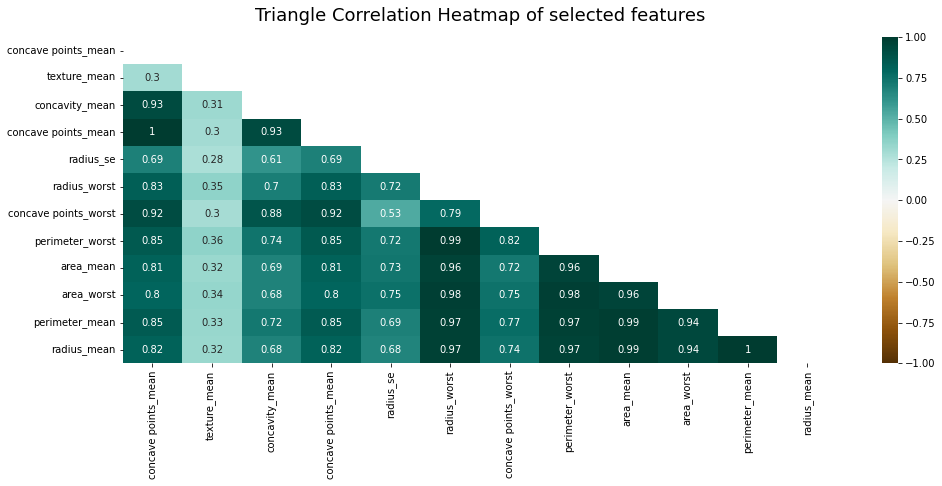

In [24]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(sel_feat.corr(), dtype=np.bool))
heatmap = sns.heatmap(sel_feat.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap of selected features', fontdict={'fontsize':18}, pad=16);
plt.show()

In [38]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

In [42]:
def plot_structure_model(sm_var, threshold=0.5):
    sm_var.remove_edges_below_threshold(threshold)
    sm_var = sm_var.get_largest_subgraph()
    viz = plot_structure(sm_var, graph_attributes={'scale': "2.0", 'size': 3.5}, all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
    return Image(viz.draw(format='png'))

In [40]:
x_selected = sel_feat.copy()

>> Using 50% sample of data 

In [ ]:
x_portion = x_selected.sample(frac=0.50, random_state=42)
sml = from_pandas(x_portion, beta=0.8,tabu_parent_nodes=['diagnosis'])

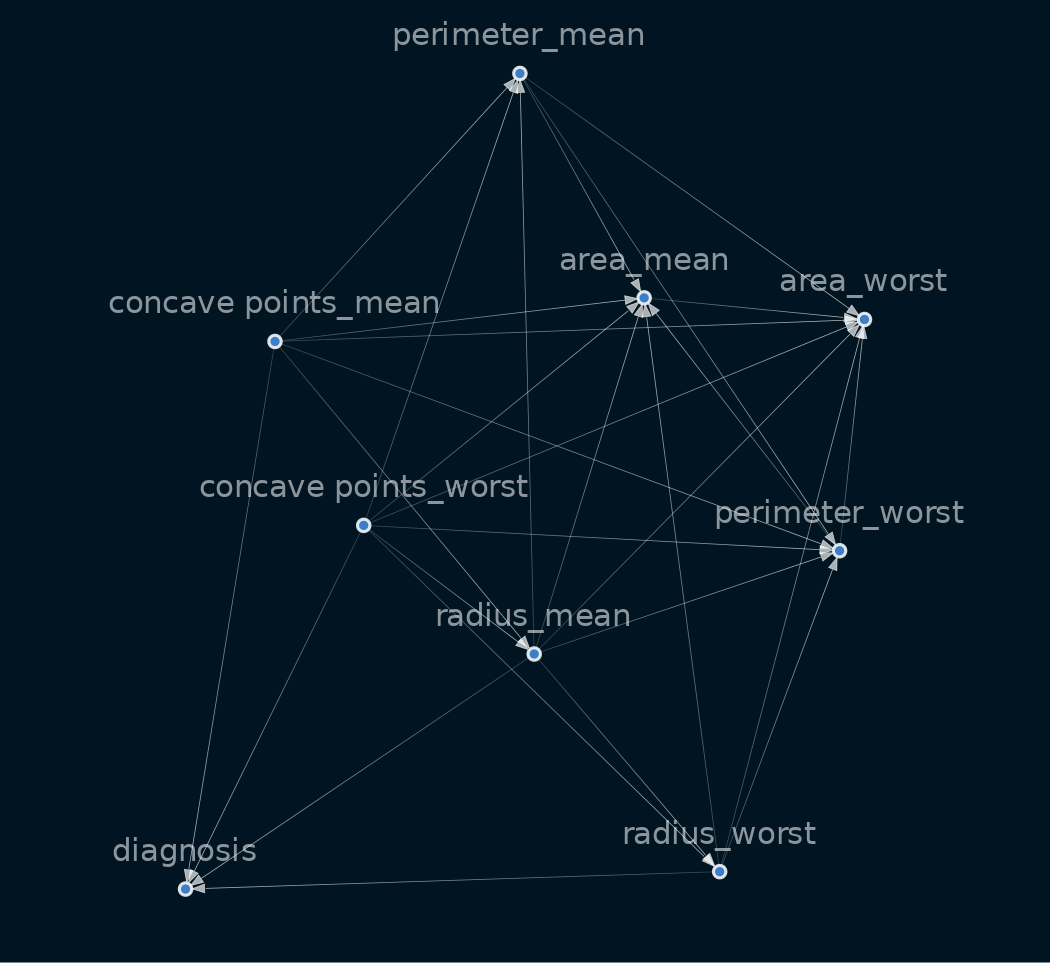

In [46]:
plot_structure_model(sml, threshold=0)

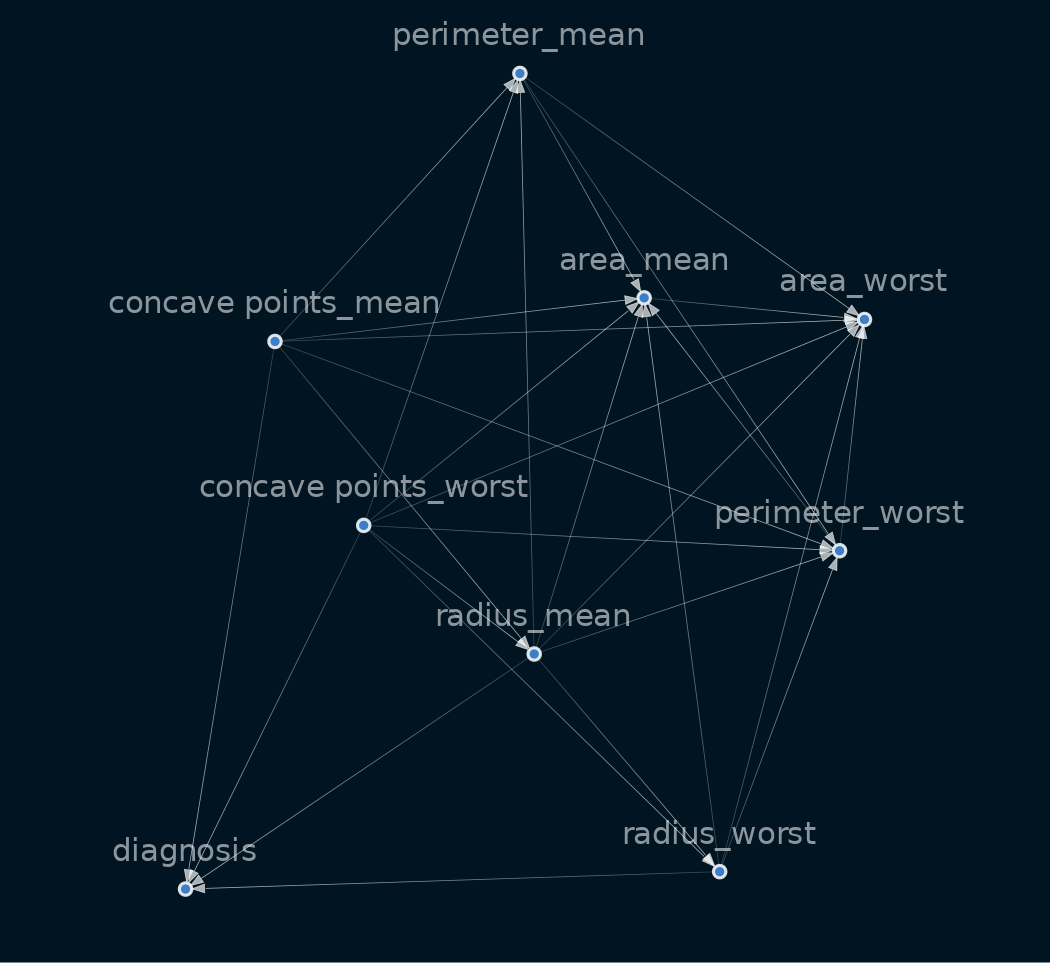

In [44]:
plot_structure_model(sml, threshold=0.1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data['diagnosis'], test_size = 0.2, random_state = 42)

Scale the data

In [34]:
scale = RobustScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Create Causal Model

In [41]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [42]:
est.dowhy.fit(X_train, y_train)

AssertionError: Can only accept single dimensional outcome.

In [ ]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"], feature_names=["income"],
               confounder_names=confounder_names, inference="statsmodels")

In [24]:
import dowhy

In [29]:
from graphviz import Source
from IPython.display import Image, display
from dowhy import CausalModel
from causalgraphicalmodels import CausalGraphicalModel

In [ ]:
graph = CausalGraphicalModel(
    nodes=[ 'is_canceled', 'lead_time', "unobserved_confounder",'total_of_special_requests',
        'meal', 'country', 'market_segment',
        'is_repeated_guest', 
       'previous_bookings_not_canceled', 'booking_changes', 'previous_cancellation','required_car_parking_spaces',
        'days_in_waiting_list',
         'total_guests',
       'total_days', 'different_room_assigned','agent'],
    edges=[
        ("market_segment", "lead_time"), 
        ("lead_time", "is_canceled"), 
        ("country", "lead_time"),
        ("different_room_assigned", "is_canceled"), 
        ("unobserved_confounder", "is_canceled"),("unobserved_confounder","lead_time"),("unobserved_confounder","different_room_assigned"),
        ("country","meal"),
        ("lead_time",'days_in_waiting_list'),
        ('days_in_waiting_list',"is_canceled"),
        ('previous_bookings_not_canceled','is_canceled'),
        ('previous_bookings_not_canceled','is_repeated_guest'),
        ('is_repeated_guest','is_canceled'),
        ('total_days',"is_canceled"),
        ('total_days',"agent"),
        ('total_guests','is_canceled'),
        ('previous_cancellation','is_canceled'),
        ('previous_cancellation','is_repeated_guest'),
        ('required_car_parking_spaces','is_canceled'),('total_guests','required_car_parking_spaces'),('total_days','required_car_parking_spaces'),
        ('total_of_special_requests','is_canceled'),
        ('booking_changes','different_room_assigned'),('booking_changes','is_canceled')
    ]
)
G=graph.draw()
G